# 0. Import dataset

To obtain the reviews, we scraped the Enola Holmes movie (2020) reviews from imdb.com into a csv file, which is imported into this notebook as the dataset

In [1]:
# Import necessary libraries

import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import numpy as numpy
import pandas as pd
import re
import spacy
from spacy import displacy

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Preliminary analysis of dataset

df = pd.read_csv('../datasets/imdb_enola_holmes/imdb_enola_holmes_reviews.csv', index_col='user_name')
print(df.head())
print()
print('No. of Samples: ', df.shape[0])

                                                       review_title  \
user_name                                                             
jesamazinghawley                        "Perfect for a 15 yro girl"   
faolanredwolf     "Not for Sherlock Holmes fans, but not bad eit...   
korpake                        "It could have been so much more..."   
zekehardrock               "Am I the only man who love this movie?"   
robertnees        "Jiu-Jitsu in the early 1900s, Yes, females an...   

                        review_date  \
user_name                             
jesamazinghawley  25 September 2020   
faolanredwolf     24 September 2020   
korpake           23 September 2020   
zekehardrock      23 September 2020   
robertnees        24 September 2020   

                                                        review_text  rating  
user_name                                                                    
jesamazinghawley  "This is the movie I wish I had at 15. This is...     

# 1. Data Preprocessing

Samples that have too little text is eliminated, and the data is evenly sampled across rating to obtain a wide spread of vocabulary.

Text(0, 0.5, 'Number of Reviews')

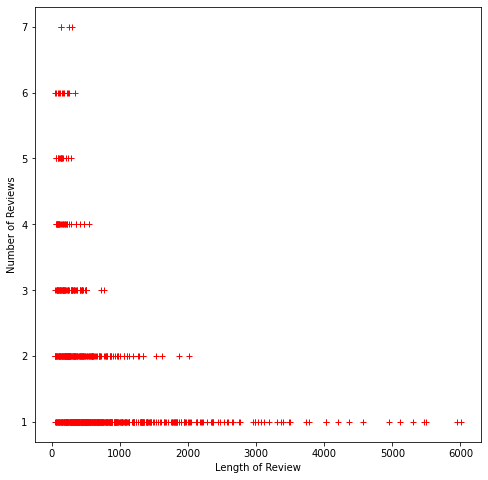

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
lengths = df['review_text'].str.len().value_counts().index.to_list()
counts = df['review_text'].str.len().value_counts().to_list()
plt.plot(lengths, counts, 'r+')
plt.xlabel('Length of Review')
plt.ylabel('Number of Reviews')

In [4]:
# Drop reviews that are less than 300 characters long

df = df.drop(df[df['review_text'].map(len) < 300].index)
print('Remaining no. of Samples: ', df.shape[0])

Remaining no. of Samples:  663


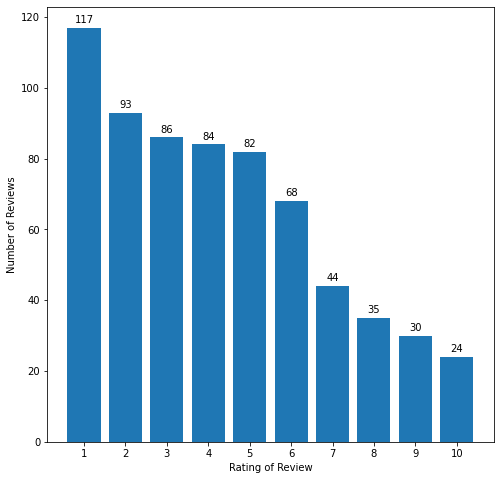

In [5]:
# Visualize Spread of Data

fig, ax = plt.subplots(figsize=(8,8))
bars = ax.bar(range(10), df['rating'].value_counts().to_list())
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(1,11))
plt.xlabel('Rating of Review')
plt.ylabel('Number of Reviews')

for rect in bars:
        height = rect.get_height()
        ax.annotate('{:d}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


In [6]:
# Sampling dataset
# No. of samples required = 30
# No. of ratings = 10
# sample size = 30/10 = 3 for each rating

df_sampled = df.groupby('rating', group_keys = False).apply(lambda x: x.sample(3, random_state=1))

# save a copy of df_sampled
df_sampled.to_csv('../datasets/imdb_enola_holmes/imdb_enola_holmes_sampled_reviews.csv')

# 2. Noun-Adjective Pair Identifier

To identify noun-adjective pairs, we have to visualize each sentence's dependency tree.

In [7]:
# First, we need to identify noun phrases
# For this study: noun phrases = nouns or compound nouns
# Pos E.g.: Millie Bobby Brown
# Neg E.g.: the cat ('the' is a determinant)

# Then, we identify the adjective/adjectival phrases
nlp = spacy.load("en_core_web_sm")
doc = nlp(df['review_text'][10])

# Retrieve adj phrase, given token is an adjective (amod)
def adj_phrase(token):
  amod = token.text
  if token.n_lefts == 0 and token.n_rights == 0:
    return amod
  for left in token.lefts:
    amod = adj_phrase(left) + ' ' + amod
  for right in token.rights:
    amod = amod + ' ' + adj_phrase(right)
  return amod

# Retrieve (noun/noun-phrase, adj/adj-phrase) pairs from given text
def get_pairs(text):
  nns = ['NOUN', 'PROPN']
  pairs = [] # (np, adj) pairs
  doc = nlp(text)
  for token in doc:
    if token.pos_ in nns:
      if token.dep_ == 'compound' and token.head.pos_ in nns:    # Ignore nouns/proper nouns that are not the root of the noun clause
        continue
          
      np = ''
      amod = []

      for child in token.children:
        if child.dep_ == 'compound':
          np = np + child.text + ' '
        if child.dep_ == 'amod':
          # print(child.text, child.dep_, child.head.text, child.head.pos_, [child for child in child.children])
          amod.extend(re.split(' and | ,', adj_phrase(child)))

      np = np + token.text
      for mod in amod:
        pairs.append( (np, mod) )
  return pairs

In [8]:
# Get highest count of noun-adj pair

pairs = []
count_pair = {}
for text in df_sampled['review_text']:
  txt_pairs = get_pairs(text)
  pairs.append(txt_pairs)

  for pair in txt_pairs:
    if pair in count_pair:
      count_pair[pair] = count_pair[pair] + 1
    else:
      count_pair[pair] = 1

In [9]:
# shows that pairs do not often occur more than once in the sampled reviews

from collections import Counter
dict(Counter(count_pair).most_common(10))

{('lead', 'female'): 3,
 ('plot', 'main'): 3,
 ('things', 'stranger'): 2,
 ('fan', 'big'): 2,
 ('empowerment', 'female'): 2,
 ('actress', 'young'): 2,
 ('leads', 'strong'): 2,
 ('leads', 'female'): 2,
 ('lead', 'strong'): 2,
 ('girls', 'young'): 2}

In [10]:
df_sampled['rating'].mean()

5.5

In [11]:
# Ranking:
# Use SentimentIntensityAnalyzer to get intensity of sentiment of noun-adj pair
# Multiply sentiment of phrase and the rating of the review to get the overall score for the ranker.

sid = SentimentIntensityAnalyzer()
scored_pairs = []
intensity_pairs = []

# normalise review ratings
for i in df_sampled.index:
  text = df_sampled['review_text'][i]
  if df_sampled['rating'][i] < 6:
    rating = (df_sampled['rating'][i] - 6)/5 
  else:
    rating = (df_sampled['rating'][i] - 5)/5 # scale rating between -1 and 1

  for np, amod in get_pairs(text):
    intensity = sid.polarity_scores(amod + ' ' + np)['compound']
    # scoring algorithm: rating * intensity
    scored_pairs.append([np, amod, intensity, rating, (rating * intensity)])
    intensity_pairs.append([np, amod, intensity, abs(intensity)])

# print results
    
df_pairs = pd.DataFrame(scored_pairs, columns = ['noun', 'adj', 'intensity', 'rating', 'score'])
df_pairs.sort_values(by='score', ascending=False, inplace=True)
df_pairs.index = numpy.arange(1, len(df_pairs) + 1)
print("Noun-Adj Pair Ranker results:")
print()
print(df_pairs.head(10))

print()

print("For reference: ranking of noun-pairs by intensity alone.")
print("We can see that there is some variation in the rankings.")
print()
df_intensity = pd.DataFrame(intensity_pairs, columns = ['noun', 'adj', 'intensity', 'abs_intensity'])
df_intensity.sort_values(by='abs_intensity', ascending=0, inplace=True)
df_intensity.reset_index(drop=True)
print(df_intensity.head(10)) 

Noun-Adj Pair Ranker results:

                noun        adj  intensity  rating    score
1            success      great     0.8316     1.0  0.83160
2         love story       cute     0.8020     1.0  0.80200
3     cinemetography  Beautiful     0.5994     1.0  0.59940
4      Saturday film   charming     0.5859     1.0  0.58590
5              tonic  wonderful     0.5719     1.0  0.57190
6                fan       huge     0.5574     1.0  0.55740
7         propaganda     stupid    -0.6597    -0.8  0.52776
8   propaganda movie     stupid    -0.6597    -0.8  0.52776
9      Saturday film        fun     0.5106     1.0  0.51060
10             movie      great     0.6249     0.8  0.49992

For reference: ranking of noun-pairs by intensity alone.
We can see that there is some variation in the rankings.

                  noun     adj  intensity  abs_intensity
258            success   great     0.8316         0.8316
250         love story    cute     0.8020         0.8020
186  adventure picture